# Lines Generator

In [1]:
from matplotlib import pyplot as plt 
from skimage.draw import line_aa,ellipse_perimeter
import numpy as np
import cv2
%matplotlib inline

## Parameters

In [2]:
size = (1280,720)

#lines
delta_lines = [3,30]
aplha_lines = [0.7,1]

#ellipses
delta_ellipses = [3,10]
aplha_ellipses = [0.7,1]
radius_ellipses = [0.1,0.7] #1 = size, ex:1280,720

#texture
n_textures = 2
alpha_textures = [0.05, 0.2] #max=1

#binary noise
binary_noise_probability = 0.003 #max=1

#smoothing
smooth_delta_kernel = [3,11] #[3,7] => (3,3)or(5,5)or(7,7)

#simple noise
noise_delta_sigma = [-10,10] #max=255

## Aux function

In [3]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    plt.show()

In [4]:
def norm(im):
    im = np.array(im).astype('float32')
    im = (im-np.min(im))*255/(np.max(im)-np.min(im))
    return im.astype('uint8')

In [5]:
im = np.zeros((size[1],size[0]))

## Add Lines

In [6]:
def add_lines(im,delta_lines,aplha_lines):
    im = im.copy()

    #Parameters
    size = im.shape
    d_max = np.floor(np.sqrt(size[0]**2+size[1]**2))-10
    n_lines = np.random.randint(delta_lines[0],delta_lines[1])
    
    #add lines
    lines = list()
    for l in range(n_lines):

        #random line
        dist = np.random.random()*d_max
        angle = np.random.random()*2*np.pi-np.pi
        alpha = np.random.random()*(aplha_lines[1]-aplha_lines[0])+aplha_lines[0]

        #save
        lines.append([dist,angle,alpha])

        #to rectangle
        pt1 = np.around(dist/np.sin(angle))                         #x=0     => [0,d/sin(o)]
        pt2 = np.around((dist-size[1]*np.cos(angle))/np.sin(angle)) #x=x_max => [x_max,(d-x_max.cos(o))/sin(o)]

        #line pixels
        rows, cols, vals = line_aa(int(pt1), 0, int(pt2), size[1])
        for r,c,v in zip(rows, cols, vals):
            try:
                im[c][r] = v*alpha
            except:#out matrix
                break
    
    return np.array(lines), norm(im)

17 lines


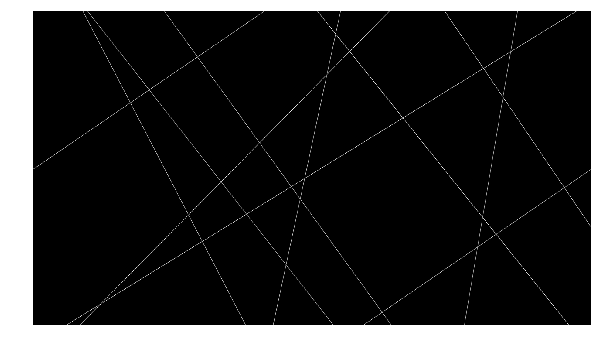

CPU times: user 322 ms, sys: 200 ms, total: 522 ms
Wall time: 469 ms


In [7]:
%%time
lines,im = add_lines(im,delta_lines,aplha_lines)
print(lines.shape[0],'lines')
imshow(im)

## Add ellipses

In [8]:
def add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses):
    im = im.copy()

    #Parameters
    size = im.shape
    #d_max = np.floor(np.sqrt(size[0]**2+size[1]**2))-10
    n_ellipses = np.random.randint(delta_ellipses[0],delta_ellipses[1])
    
    #add ellipses
    for e in range(n_ellipses):

        #random center
        center_x = np.random.randint(0,size[1])
        center_y = np.random.randint(0,size[0])
        
        #random radius
        radius_x = np.random.random()*(size[1]*radius_ellipses[1]-size[1]*radius_ellipses[0])\
                   +size[1]*radius_ellipses[0]
        radius_y = np.random.random()*(size[0]*radius_ellipses[1]-size[0]*radius_ellipses[0])\
                   +size[0]*radius_ellipses[0]
        radius_x = int(radius_x)
        radius_y = int(radius_y)
        
        #random alpha
        alpha = np.random.random()*(aplha_ellipses[1]-aplha_ellipses[0])+aplha_ellipses[0]
        
        #create ellipse
        pixels_y, pixels_x = ellipse_perimeter(center_y, center_x, radius_y, radius_x, shape = size)
        vals = im[pixels_y,pixels_x]+255*alpha
        vals[vals>255] = 255
        im[pixels_y,pixels_x] = vals

    return norm(im)

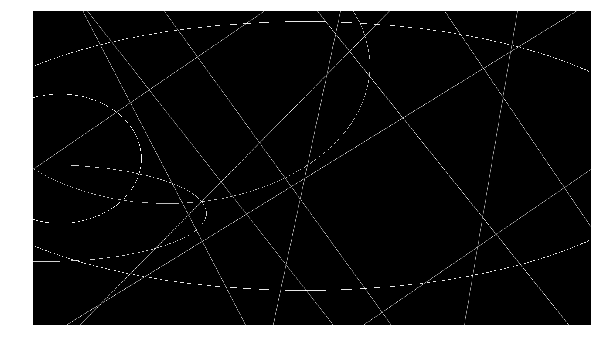

CPU times: user 237 ms, sys: 148 ms, total: 385 ms
Wall time: 207 ms


In [9]:
%%time
im = add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses)
imshow(im)

## Texture
Load all textures:

In [10]:
def load_textures(n_textures):

    ims_texture = list()
    for t in range(n_textures):
        #load
        ims_texture.append(cv2.imread('imgs/texture'+str(t+1)+'.jpg',cv2.IMREAD_GRAYSCALE))
        #resize
        ims_texture[-1] = cv2.resize(ims_texture[-1], size)
        #normalize
        ims_texture[-1] = norm(ims_texture[-1])

    return np.array(ims_texture)

Add texture:

In [11]:
def add_texture(im, ims_texture,alpha_textures):
    im = im.copy()
    
    #random texture
    n_textures = ims_texture.shape[0]
    i_texture = np.random.randint(0,n_textures)
    alpha = np.random.random()*(alpha_textures[1]-alpha_textures[0])+alpha_textures[0]

    #add 
    im = im+ims_texture[i_texture]*alpha

    #print('i:',i_texture,' alpha:',alpha)
    return norm(im)

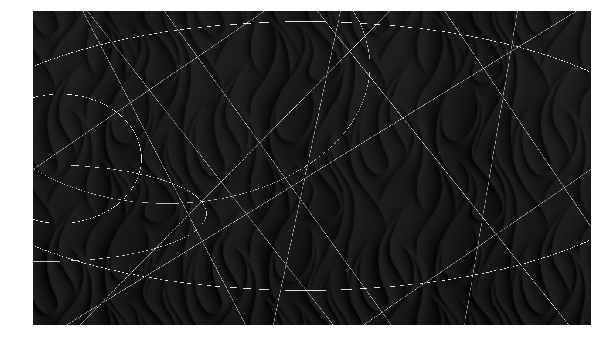

CPU times: user 389 ms, sys: 169 ms, total: 559 ms
Wall time: 590 ms


In [12]:
%%time
ims_texture = load_textures(n_textures)
im = add_texture(im, ims_texture,alpha_textures)
imshow(im)

## Binary Noise

In [13]:
def add_binary_noise(im,noise_probability):
    im = im.copy().astype('int16')
    
    #random image [0,1]
    im_prob = np.random.random(im.shape)

    #invert some pixels 
    #im[im_prob<noise_probability] = 255-im
    im[im_prob<noise_probability] *= -1
    im[im_prob<noise_probability] += 255
         
    return norm(im)

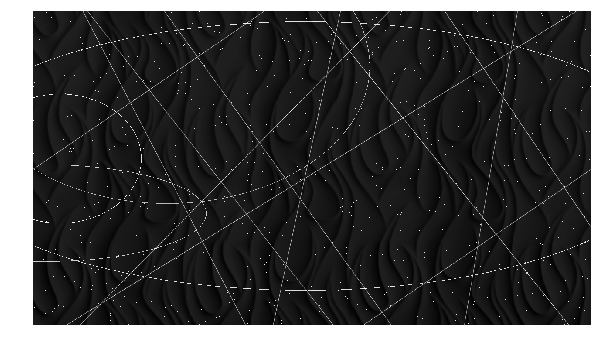

CPU times: user 356 ms, sys: 170 ms, total: 526 ms
Wall time: 333 ms


In [14]:
%%time
im = add_binary_noise(im,binary_noise_probability)
imshow(im)

## Smoothing

In [15]:
def smoothing(im,delta_kernel):
    im = im.copy()
    
    #random kernel, only odd
    kernel = np.random.randint(delta_kernel[0]/2,delta_kernel[1]/2+1)
    kernel = kernel*2+1
    
    #gaussian filter
    im = cv2.GaussianBlur(im,(kernel,kernel),-1)

    return norm(im)

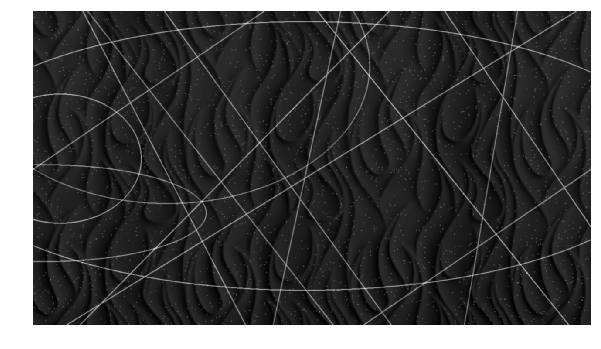

CPU times: user 329 ms, sys: 182 ms, total: 512 ms
Wall time: 431 ms


In [16]:
%%time
im = smoothing(im,smooth_delta_kernel)
imshow(im)

## Noise

In [17]:
def add_noise(im,delta_sigma):
    im = im.copy()
    
    #random noise
    im_noise = np.random.randint(delta_sigma[0],delta_sigma[1],im.shape)
    im_noise = im + im_noise
    
    #limits
    im_noise[im_noise>255] = 255
    im_noise[im_noise<0] = 0
    
    return norm(im_noise)

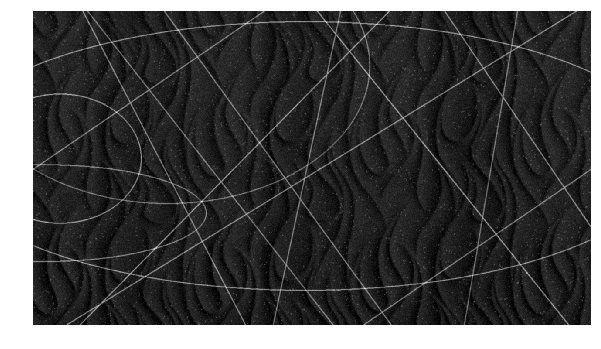

CPU times: user 373 ms, sys: 185 ms, total: 558 ms
Wall time: 332 ms


In [18]:
%%time
im = add_noise(im,noise_delta_sigma)
imshow(im)

## Equalize

In [19]:
from skimage.exposure import equalize_hist
def equalize(im):
    im = im.copy()
    im = equalize_hist(im,mask = (im!=0))
    return norm(im)

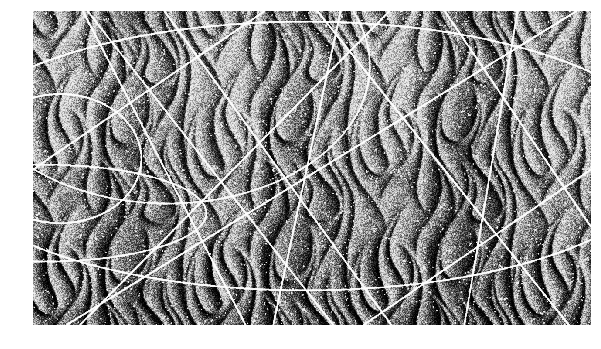

CPU times: user 453 ms, sys: 181 ms, total: 634 ms
Wall time: 412 ms


In [20]:
%%time
im_eq = equalize(im)
imshow(im_eq)

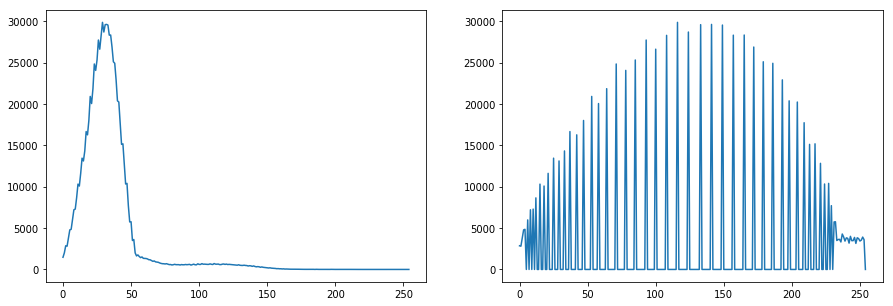

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

hist = cv2.calcHist([im,],[0],None,[256],[0,256])
hist_eq = cv2.calcHist([im_eq],[0],None,[256],[0,256])

ax[0].plot(hist[1:],'-')
ax[1].plot(hist_eq[1:],'-')

## Image generator

In [22]:
def im_generator(n_images=1,
                 size = size,
                 delta_lines = delta_lines,
                 aplha_lines = aplha_lines,
                 delta_ellipses = delta_ellipses,
                 radius_ellipses = radius_ellipses,
                 aplha_ellipses = aplha_ellipses,                 
                 n_textures = n_textures,
                 alpha_textures = alpha_textures,
                 binary_noise_probability = binary_noise_probability,
                 smooth_delta_kernel = smooth_delta_kernel,
                 noise_delta_sigma = noise_delta_sigma):
    
    #load textures
    ims_texture = load_textures(n_textures)
    
    ims = list()
    lines_list = list()
    for i in range(n_images):
        #black image
        im = np.zeros((size[1],size[0]))

        #Add Lines
        lines,im = add_lines(im,delta_lines,aplha_lines)
        
        #Add Ellipses
        im = add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses)
            
        #Add Texture
        im = add_texture(im, ims_texture,alpha_textures)

        #Add Binary Noise
        im = add_binary_noise(im,binary_noise_probability)

        #Smoothing
        im = smoothing(im,smooth_delta_kernel)

        #Add Noise
        im = add_noise(im,noise_delta_sigma)
        
        #Equalize
        im = equalize(im)
        
        #Lines
        ims.append(im)
        lines_list.append(lines)
    
    #to numpy
    ims = np.array(ims)
    lines_list = np.array(lines_list)
    
    return lines_list,ims

(1, 29, 3)


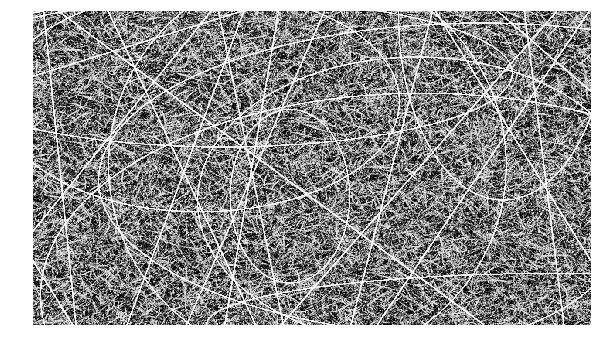

CPU times: user 600 ms, sys: 216 ms, total: 816 ms
Wall time: 586 ms


In [23]:
%%time
lines, ims = im_generator()
print(lines.shape)
imshow(ims[0])

In [24]:
%%time
lines,ims = im_generator(10)

CPU times: user 3.27 s, sys: 466 ms, total: 3.74 s
Wall time: 3.73 s


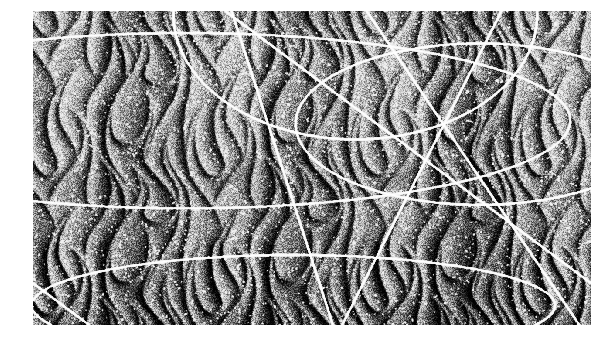

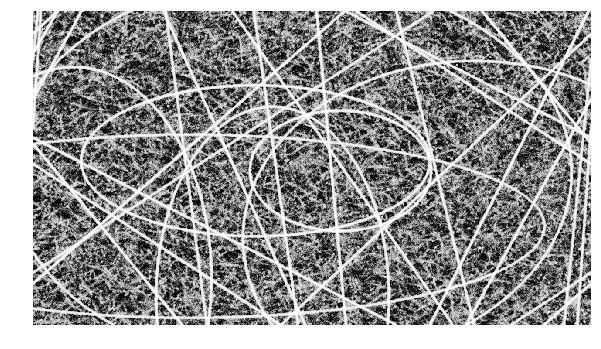

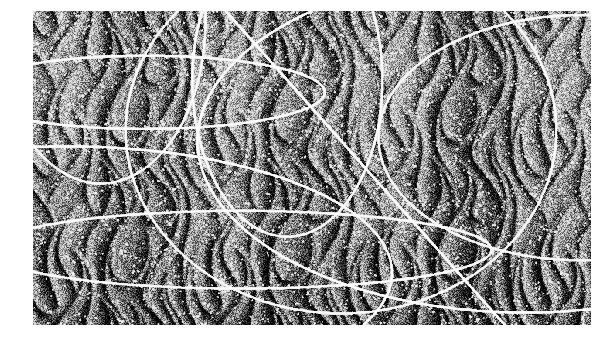

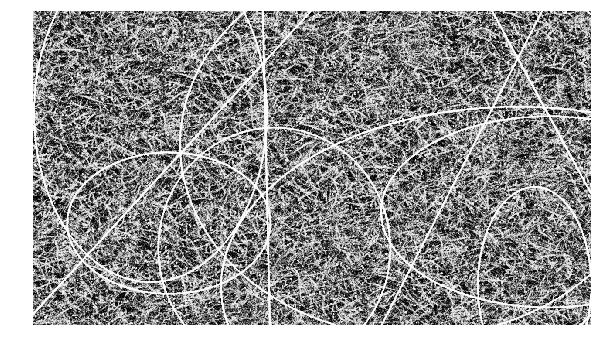

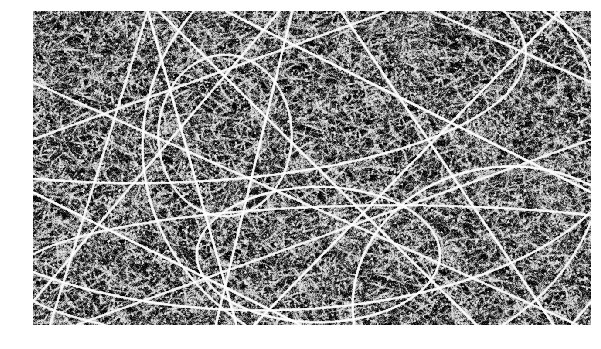

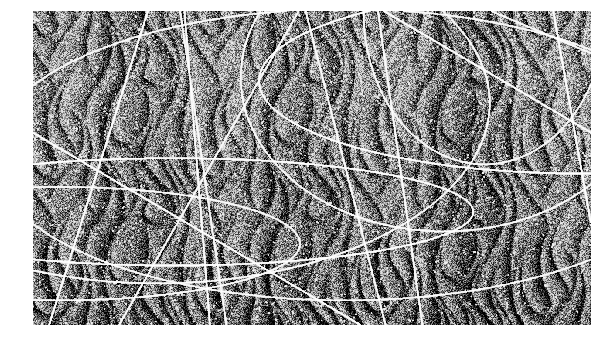

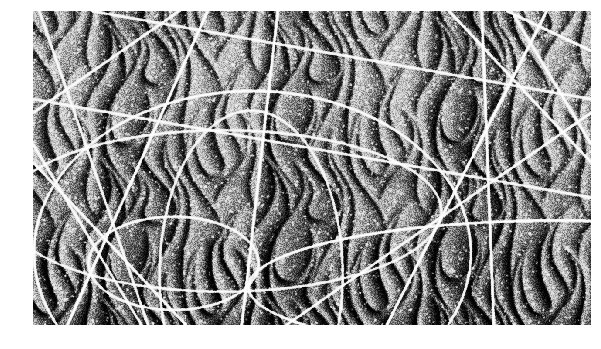

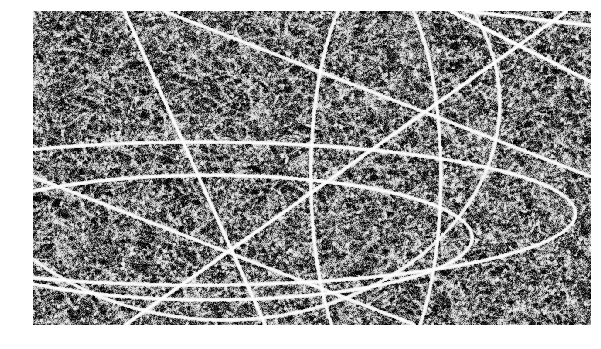

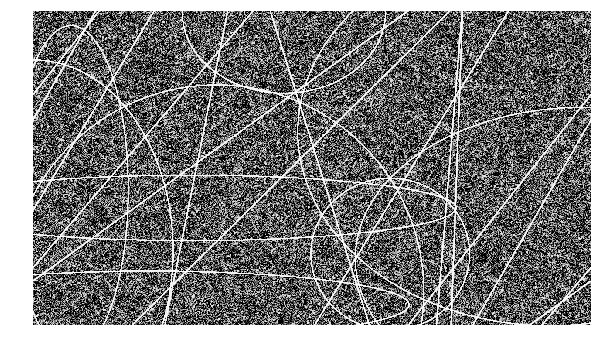

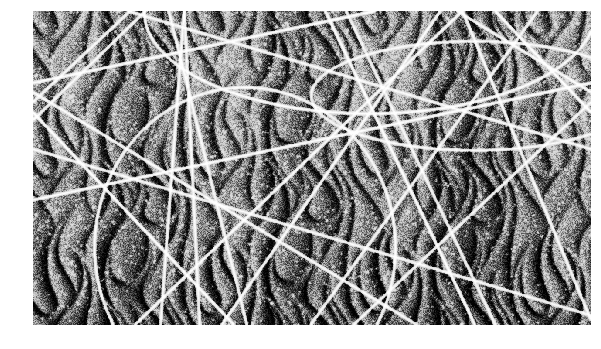

In [25]:
for im in ims:
    imshow(im)